In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform=transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        ])
dataset1 = datasets.MNIST('dataset', train=True, download=True,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, drop_last=True)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to dataset\MNIST\raw\train-images-idx3-ubyte.gz
9920512it [00:03, 2644856.60it/s]
Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw
0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to dataset\MNIST\raw\train-labels-idx1-ubyte.gz
32768it [00:00, 76571.25it/s]
0it [00:00, ?it/s]Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw
1654784it [00:01, 1376549.22it/s]
0it [00:00, ?it/s]Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw
8192it [00:00, 27064.33it/s]Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw
Processing...
Done!



In [3]:
#Networks-Discriminator, Generator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 1)
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc1(x))
        return x


class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        hid = 64
        self.convT1 = nn.ConvTranspose2d(input_dim, hid * 8, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(hid * 8)
        self.convT2 = nn.ConvTranspose2d(hid * 8, hid * 4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(hid * 4)
        self.convT3 = nn.ConvTranspose2d(hid * 4, hid * 2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(hid * 2)
        self.convT4 = nn.ConvTranspose2d(hid * 2, hid, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(hid)
        self.convT5 = nn.ConvTranspose2d(hid, 1, kernel_size=4, stride=2, padding=1)
    
    def forward(self, z):
        x = F.relu(self.bn1(self.convT1(z)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = F.tanh(self.convT5(x))
        return x
        

#networks
netD = Discriminator(3).cuda()
netG = Generator(100).cuda()
#loss function
loss_fn = nn.BCELoss()
real_label = 1.
fake_label = 0.
real_labels = torch.full((64,), real_label, dtype=torch.float32).cuda()
fake_labels = torch.full((64,), fake_label, dtype=torch.float32).cuda()
#optimizers
optimizerD = optim.Adam(netD.parameters())
optimizerG = optim.Adam(netG.parameters())
    

In [6]:
generated_images = []
num_epochs = 15
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        #update discriminator
        netD.zero_grad()
        inputs, _ = data
        inputs = inputs.cuda()
        real_dis_preds = netD(inputs).view(-1)
        loss_real = loss_fn(real_dis_preds, real_labels)
        loss_real.backward()
        netG.zero_grad()
        random_noise = torch.randn(64, 100, 1, 1).cuda()
        fake_images = netG(random_noise)
        fake_dis_pred = netD(fake_images.detach()).view(-1)
        fake_loss = loss_fn(fake_dis_pred, fake_labels)
        fake_loss.backward()
        optimizerD.step()
        dis_error = loss_real + fake_loss
        #update generator
        dis_out = netD(fake_images).view(-1)
        gen_loss = loss_fn(dis_out, real_labels)
        gen_loss.backward()
        optimizerG.step()
        if not i % 300:
            with torch.no_grad():
                image = netG(random_noise).permute(0, 2, 3, 1).cpu().detach().numpy()
                generated_images.append(image)
    print(f"[Epoch {epoch}] Discriminator loss: {dis_error}, Generator loss: {gen_loss}")

[Epoch 0] Discriminator loss: 0.002059811959043145, Generator loss: 8.83784294128418
[Epoch 1] Discriminator loss: 3.763107815757394e-05, Generator loss: 11.564376831054688
[Epoch 2] Discriminator loss: 0.4788120985031128, Generator loss: 6.304744720458984
[Epoch 3] Discriminator loss: 0.6451706290245056, Generator loss: 3.9402053356170654
[Epoch 4] Discriminator loss: 1.1512235403060913, Generator loss: 2.8453335762023926
[Epoch 5] Discriminator loss: 1.468709111213684, Generator loss: 3.1996843814849854
[Epoch 6] Discriminator loss: 0.1731031984090805, Generator loss: 6.585732460021973
[Epoch 7] Discriminator loss: 1.493459701538086, Generator loss: 1.1346502304077148
[Epoch 8] Discriminator loss: 1.1713683605194092, Generator loss: 1.4618096351623535
[Epoch 9] Discriminator loss: 0.17799022793769836, Generator loss: 7.732659339904785
[Epoch 10] Discriminator loss: 0.7668145895004272, Generator loss: 1.103270173072815
[Epoch 11] Discriminator loss: 0.08917415887117386, Generator loss

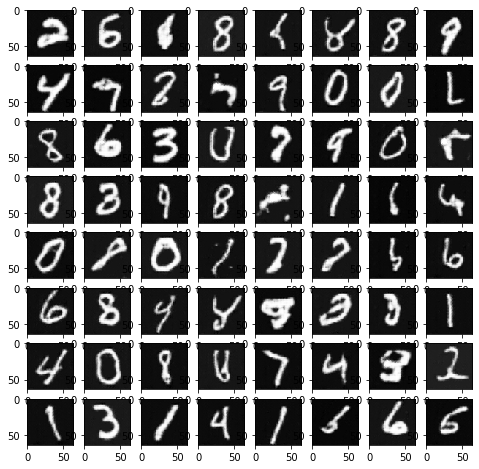

In [9]:
columns = 8
rows = 8
img_list = np.array(generated_images, dtype=np.float32)[-1]
fig = plt.figure(figsize=(8,8))
plt.axis("off")
for i in range(1, columns*rows+1):
    img = img_list[i-1].reshape((64, 64))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()